# LC-MS: MS identified Features Neg 


In [1]:
import pandas as pd
import numpy as np
import os
import openpyxl

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2


from itertools import combinations
from sklearn.decomposition import PCA
from scipy.stats import zscore, entropy, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cross_decomposition import CCA


from sklearn.ensemble import IsolationForest

%matplotlib inline

In [2]:
# set the directory 
os.chdir('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results')

In [38]:
# Define the color palette for the sample types
sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

sns.set_style(style="white")

# 1. Load data

In [4]:
# order
samples = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/Order_34707_orderitem.csv')

# Extract the list of sample names
sample_names = samples['Sample Name'].tolist()
# Create a new dataframe 'sample_md' with selected column
sample_md = samples[['Sample Name']].copy()
# Split 'Sample Name' into new columns
sample_md[['sample_type', 'year', 'plot']] = sample_md['Sample Name'].str.split('_', expand=True)

# modify and save the metadata for the PERMANOVA 
sample_md_save = sample_md.copy()
sample_md_save.rename(columns={'Sample Name':'sample_id'}, inplace=True)
sample_md_save.set_index('sample_id').to_csv('LC-MS_metadata.csv', index=1)

sample_md.head()

,Sample Name,sample_type,year,plot
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17


In [5]:
# Get the raw data
file_path_MS1MS2 = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_MS1_MS2_Features_NEG.xlsx"
file_path_MS2 = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_MS2_Features_NEG.xlsx"

# Read only the 'Area_Stats' sheet
df_MS1MS2 = pd.read_excel(file_path_MS1MS2, sheet_name="Compounds")
df_MS2 = pd.read_excel(file_path_MS2, sheet_name="Compounds")

In [6]:
print('MS1/MS2')
print('Uniquely annotated features: ' + str(df_MS1MS2['Name'].notna().sum()))

MS1/MS2
Uniquely annotated features: 1389


In [7]:
print('MS2')
print('Uniquely annotated features: ' + str(df_MS2['Name'].notna().sum()))


MS2
Uniquely annotated features: 170


# MS1/MS2 Data prep

In [8]:
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [
    col for col in df_MS1MS2.columns
    if any(sample in col for sample in sample_names) and col.startswith('Norm. Area')] # Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df_MS1MS2 = df_MS1MS2[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df_MS1MS2.set_index('Name', inplace=True)

df_MS1MS2.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
(+)-abscisic acid beta-D-glucopyranosyl ester,2.853180e+06,1.674791e+06,4.997254e+06,1.437275e+06,2.558985e+06,1.847276e+06,9.228488e+05,1.584997e+06,1.790718e+06,1.621998e+06,...,1.780244e+06,1.389901e+06,6.990081e+05,1.432234e+06,9.931884e+05,1.086032e+06,2.199314e+06,8.058211e+05,1.157642e+06,9.369923e+05
(+)-applanatumol Z5,2.069700e+05,1.928526e+05,2.120696e+05,1.961688e+05,1.927815e+05,1.980027e+05,2.322184e+05,2.325170e+05,1.880515e+05,1.954893e+05,...,1.032495e+06,5.993583e+05,5.252317e+05,5.258716e+05,1.383129e+06,7.663592e+05,1.251228e+06,1.352524e+06,3.997231e+06,1.514639e+05
(+)-daeschol A,6.638892e+05,5.837955e+05,1.265237e+06,7.597431e+05,8.813888e+05,7.644456e+05,5.914671e+05,3.795500e+05,7.499696e+05,5.430114e+05,...,2.883634e+05,2.992945e+05,1.752104e+05,2.932962e+05,1.033874e+05,1.178132e+05,2.986076e+05,2.824206e+05,6.425445e+05,3.708816e+05
(+)-discoipyrrole A,8.452034e+05,1.188752e+06,8.830081e+05,6.471739e+05,2.649399e+06,1.885669e+06,9.167222e+05,2.408478e+05,1.307421e+06,4.932804e+05,...,6.270955e+05,1.416850e+05,3.048497e+05,1.750752e+05,2.909879e+05,4.816050e+05,1.408526e+06,4.573997e+05,3.405656e+05,1.342221e+05
(+)-pestalachloride E,1.786221e+06,1.253549e+06,2.678733e+06,1.387635e+06,2.359057e+06,1.371396e+06,1.322883e+06,6.249601e+06,1.104926e+06,1.610949e+06,...,3.400553e+07,7.429170e+06,5.765268e+06,1.565155e+07,1.190213e+07,1.393720e+06,9.326126e+06,1.036025e+07,1.360515e+07,1.070903e+07


In [9]:
## MERGE samples with metadata
df_MS1MS2 = df_MS1MS2.T  # Transpose so samples are rows, features are columns
df_MS1MS2.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_MS1MS2_wMetadata = sample_md.merge(df_MS1MS2, on='Sample Name')

df_MS1MS2_wMetadata.head()

,Sample Name,sample_type,year,plot,(+)-abscisic acid beta-D-glucopyranosyl ester,(+)-applanatumol Z5,(+)-daeschol A,(+)-discoipyrrole A,(+)-pestalachloride E,(+/-)-Gingerol,...,Yersiniabactin,Zeamine II,Zeamine II,Zeamine II,Zearalenone,Zosterin,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,783785.124454,6.549559e+05,121522.935182,137325.385628,2.531708e+07,2.728264e+07,...,2.218193e+06,2.955269e+06,4.604274e+05,200110.393248,8.314012e+05,137080.864179,1.112264e+06,1.507527e+06,358800.378920,6.463435e+07
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,141159.349488,7.808954e+05,188463.905654,142846.141138,3.196022e+07,2.276051e+07,...,2.599382e+05,2.071510e+06,4.458950e+05,234095.318249,1.349134e+06,129874.107159,1.105473e+06,1.318371e+06,442733.713939,4.939247e+07
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,350055.526442,5.672757e+05,110459.612472,150536.333853,2.692962e+07,2.378165e+07,...,3.627925e+05,3.137651e+06,6.221710e+05,173727.629627,9.472279e+05,123888.004350,1.151447e+06,1.836374e+06,359466.563611,1.973607e+07
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,320967.503821,4.097860e+05,313877.600431,406813.234210,4.623715e+05,8.725177e+07,...,2.764654e+06,7.099011e+06,2.617942e+06,645232.448495,4.077015e+06,476398.449270,5.882065e+05,4.863320e+05,979455.842259,1.758999e+05
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,195418.738996,5.749223e+06,146380.225778,233260.676280,1.302244e+07,2.467906e+07,...,1.156300e+06,9.891780e+05,5.009903e+05,180326.913562,1.184830e+06,132489.266857,2.069949e+06,1.219820e+06,347603.303545,8.131816e+07


### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [10]:
# Shannon entropy calculation
def shannon_entropy(values):
    """Calculate Shannon entropy for a given array of values."""
    # Normalize the values to get probabilities
    value_counts = values.value_counts(normalize=True)
    return entropy(value_counts)

# Function to apply Shannon entropy to the dataframe
def shannon_diversity_df(df):
    """Calculate Shannon Diversity for each column in a DataFrame."""
    shannon_diversity_values = {}
    for column in df.columns:
        shannon_diversity_values[column] = shannon_entropy(df[column])
    return pd.Series(shannon_diversity_values)

In [11]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_MS1MS2_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_MS1MS2_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_MS1MS2_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [12]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.00044762829000242967
ANOVA 2023 vs 2021 p-value: 0.505951483524709
ANOVA 2022 vs 2021 p-value: 0.32499647324122055


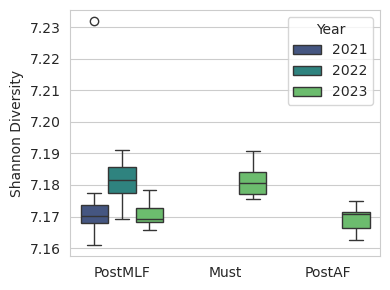

In [13]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [14]:
def richness(df):
    """Calculate richness (number of unique values) for each row in the DataFrame."""
    return df.apply(lambda x: x.nunique(), axis=1)

In [15]:
# Calculate richness for each sample (row)
richness_values = richness(df_MS1MS2_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_MS1MS2_wMetadata['sample_type'].values
richness_df['Year'] = df_MS1MS2_wMetadata['year'].values

In [16]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.0004725218977807727
ANOVA 2023 vs 2021 p-value: 0.4921127552897624
ANOVA 2022 vs 2021 p-value: 0.35995069479991604


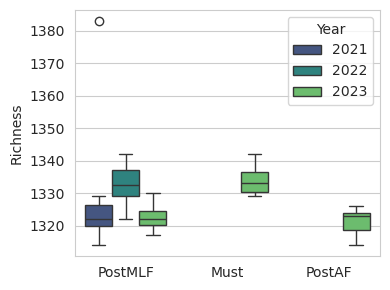

In [17]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [18]:
df_MS1MS2_wMetadata.iloc[:, 4:] = np.log1p(df_MS1MS2_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_MS1MS2_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_MS1MS2_wMetadata.iloc[:, 4:])

df_MS1MS2_wMetadata.set_index('Sample Name', inplace=True)

In [19]:
df_MS1MS2_wMetadata.shape

(52, 1392)

### Remove outliers

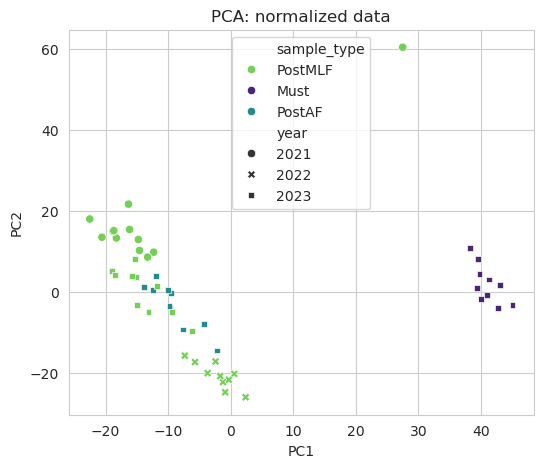

In [20]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS1MS2_wMetadata.iloc[:, 3:])

df_pca = df_MS1MS2_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [21]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_MS1MS2_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_MS1MS2_wMetadata_cleaned = df_MS1MS2_wMetadata[outlier_labels == 1]
df_MS1MS2_wMetadata_cleaned.shape

(49, 1392)

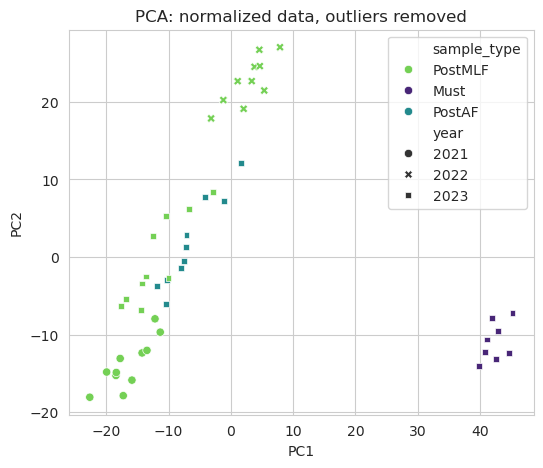

In [22]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS1MS2_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_MS1MS2_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, outliers removed')
plt.show()


In [23]:
# save
df_MS1MS2_wMetadata_cleaned.to_csv('Neg_MS1MS2_OutlierRemoved.csv')

# MS2 Data prep

In [24]:
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [
    col for col in df_MS2.columns
    if any(sample in col for sample in sample_names) and col.startswith('Norm. Area')] # Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df_MS2 = df_MS2[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df_MS2.set_index('Name', inplace=True)

df_MS2.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
L-(+)-Tartaric acid,5.766151e+09,4.375107e+09,5.599272e+09,5.129382e+09,4.964069e+09,5.087745e+09,5.300703e+09,5.781740e+09,4.773794e+09,5.860714e+09,...,6.403224e+09,6.466310e+09,7.215976e+09,6.556488e+09,6.197522e+09,5.904291e+09,6.202845e+09,5.449054e+09,7.003324e+09,6.766746e+09
Citric acid,9.657294e+08,1.601360e+09,8.260768e+08,7.060494e+08,8.568581e+08,8.053200e+08,9.514907e+08,8.277443e+08,1.009239e+09,9.025523e+08,...,2.810438e+08,2.631039e+08,3.501212e+08,2.790834e+08,2.555773e+08,3.046246e+08,2.673418e+08,3.272705e+08,3.401947e+08,2.589007e+08
2-Isopropylmalic acid,2.599297e+06,1.418409e+06,2.152783e+06,2.994341e+06,3.745819e+06,1.670365e+06,1.705628e+06,6.369054e+05,4.526980e+06,3.637680e+06,...,9.029854e+08,6.620599e+08,8.003136e+08,1.088324e+09,8.419535e+08,1.158856e+09,6.008950e+08,7.967854e+08,1.113667e+09,7.860774e+08
Citric acid,1.731422e+09,1.601360e+09,1.444979e+09,1.571177e+09,1.531996e+09,1.764813e+09,1.082796e+09,1.335542e+09,1.755452e+09,1.447244e+09,...,1.348834e+07,1.378316e+07,1.704360e+07,1.467271e+07,9.814277e+06,1.601660e+07,9.634650e+06,1.493068e+07,1.404558e+07,1.285745e+07
D-α-Hydroxyglutaric acid,1.286090e+07,1.213908e+07,5.418484e+06,1.614044e+07,1.469094e+07,2.567809e+07,1.028968e+07,1.436205e+07,3.366823e+07,1.268822e+07,...,3.363225e+08,4.731561e+08,3.855978e+08,5.190443e+08,4.209308e+08,5.392582e+08,3.729935e+08,5.268089e+08,4.380080e+08,6.233719e+08


In [25]:
## MERGE samples with metadata
df_MS2 = df_MS2.T  # Transpose so samples are rows, features are columns
df_MS2.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_MS2_wMetadata = sample_md.merge(df_MS2, on='Sample Name')

df_MS2_wMetadata.head()

,Sample Name,sample_type,year,plot,L-(+)-Tartaric acid,Citric acid,2-Isopropylmalic acid,Citric acid,D-α-Hydroxyglutaric acid,D-α-Hydroxyglutaric acid,...,Linoleic Acid,Cer-AP t40:1,NP-008309,"N-(1-Amino-1-oxo-2-propanyl)-3-[(cyclohexylcarbamoyl)amino]-1,4,5-trihydroxycyclohexanecarboxamide","Trichothec-9-ene-3-α,4-β,8-α,15-tetrol, 12,13-epoxy-",NP-001596,Quercetin,"3-Hydroxy-3,5,5-trimethyl-4-(3-oxo-1-buten-1-ylidene)cyclohexyl β-D-glucopyranoside","3,4-Bis(3-Methoxyanilino)cyclobut-3-ene-1,2-dione",L(-)-Fucose
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,5.123616e+09,1.418283e+09,6.985662e+08,7.929678e+08,3.781669e+08,2.286426e+08,...,104918.784728,3.089354e+05,1.375439e+06,443223.946381,1.084620e+05,476873.658200,9.676108e+05,522748.351769,166975.243542,478965.403873
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,4.994413e+09,1.685141e+09,7.663356e+08,8.515312e+08,3.429355e+08,1.562314e+08,...,96673.930633,2.907665e+05,1.496218e+06,548721.579898,2.656264e+05,695356.830327,5.970720e+05,523647.304110,165700.075584,573650.816303
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,7.176835e+09,1.760930e+09,7.022706e+08,8.967864e+08,3.728063e+08,1.954577e+08,...,92484.202848,3.001120e+05,1.192825e+06,389614.068080,1.492389e+06,810802.133590,4.796279e+05,420961.254396,183804.487918,770089.082641
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,6.869838e+05,7.004427e+05,1.219282e+06,1.492278e+05,6.740319e+05,3.139173e+05,...,308429.153459,1.041010e+06,3.260361e+05,415929.549435,3.241859e+05,397300.229872,2.965108e+06,274272.853813,484398.846599,400158.713684
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,4.425471e+09,1.497236e+09,1.023169e+09,8.906392e+08,3.844484e+08,6.662864e+08,...,86592.536608,2.827517e+05,1.144634e+06,403872.832290,1.053514e+05,641551.655729,7.996437e+05,572522.674448,163616.549327,670952.476998


### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [26]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_MS2_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_MS2_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_MS2_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [27]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.2789692225398474
ANOVA 2023 vs 2021 p-value: 0.09717640585898488
ANOVA 2022 vs 2021 p-value: 0.017708814474939466


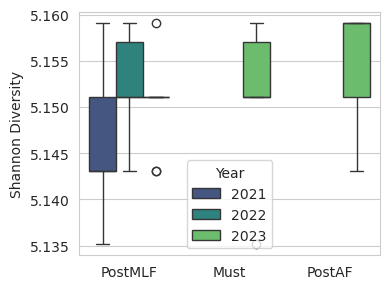

In [28]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [29]:
# Calculate richness for each sample (row)
richness_values = richness(df_MS2_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_MS2_wMetadata['sample_type'].values
richness_df['Year'] = df_MS2_wMetadata['year'].values

In [30]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.2789692225398474
ANOVA 2023 vs 2021 p-value: 0.09717640585898926
ANOVA 2022 vs 2021 p-value: 0.017708814474938907


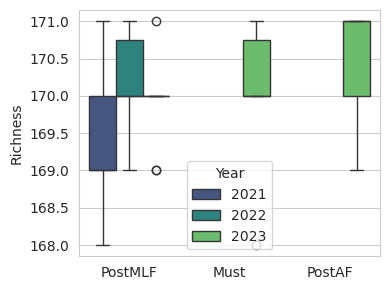

In [ ]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [32]:
df_MS2_wMetadata.iloc[:, 4:] = np.log1p(df_MS2_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_MS2_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_MS2_wMetadata.iloc[:, 4:])

df_MS2_wMetadata.set_index('Sample Name', inplace=True)

In [33]:
df_MS2_wMetadata.shape

(52, 173)

### Remove outliers

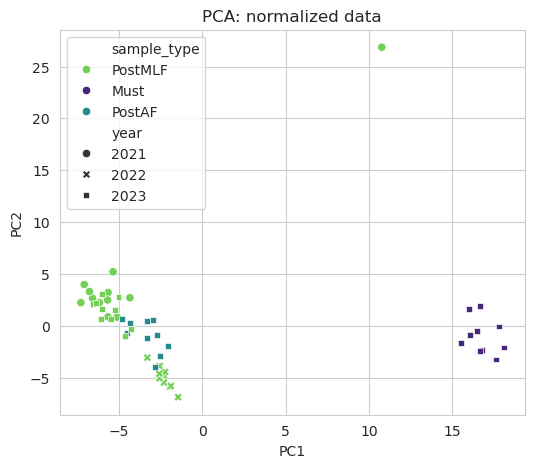

In [34]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS2_wMetadata.iloc[:, 3:])

df_pca = df_MS2_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [35]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_MS2_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_MS2_wMetadata_cleaned = df_MS2_wMetadata[outlier_labels == 1]
df_MS2_wMetadata_cleaned.shape

(49, 173)

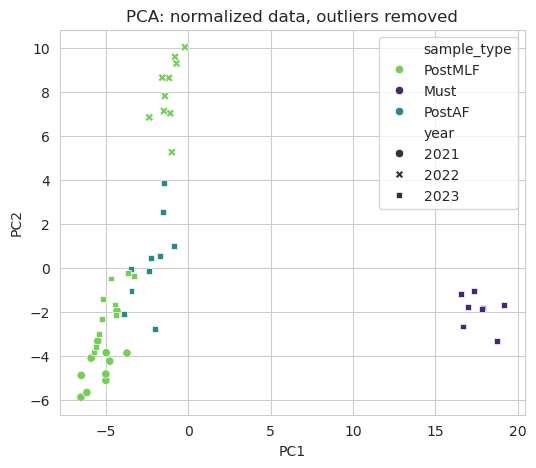

In [36]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS2_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_MS2_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, outliers removed')
plt.show()


In [37]:
# save
df_MS2_wMetadata_cleaned.to_csv('Neg_MS2_OutlierRemoved.csv')

### PostMLF PCA

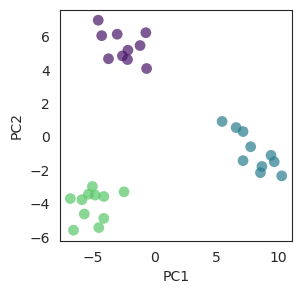

In [46]:
postMLF_df = df_MS2_wMetadata_cleaned[df_MS2_wMetadata_cleaned['sample_type'] == 'PostMLF']

pca = PCA(n_components=2)
pca_scores = pca.fit_transform(postMLF_df.iloc[:, 3:])

df_pca = postMLF_df[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

# Define colors 
sample_colors = {'2021': '#56C667FF', 
                 '2022': '#287D8EFF', 
                 '2023': '#481568FF'}

plt.figure(figsize=(3, 3)) 
sns.scatterplot(
    x='PC1', y='PC2',
    data=df_pca,
    hue='year',
    palette=sample_colors,  
    s=60, edgecolor='none', alpha=0.7, legend=False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()